In [1]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision
import torch.optim as optim


import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import top_k_accuracy_score

import timm
import json, os

In [2]:
# HYPERPARAMETERS

train_size = 0.8
test_size=0.2
cuda = 'cuda'
cpu = 'cpu' 
device = cuda if torch.cuda.is_available() else cpu


In [3]:
with open("mapping.json", 'r') as f:
    mapping = json.load(f)
    

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(degrees=15, translate= (.15, .15), scale = (0.85, 1.15)),

    transforms.Resize(324), #Resize data to be 224x224.
    transforms.RandomCrop(299),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((324, 324)),
    transforms.TenCrop((299, 299)),
    transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])),
    ])

In [4]:

class myDataset(torch.utils.data.Dataset):

    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        x, y = self.data[index]
        if self.transform:
            x = self.transform(x)
        return x, y
   


In [5]:

full_dataset = torchvision.datasets.ImageFolder(
    root='./dataset',
    transform=None
)

train, test = random_split(full_dataset, [train_size, test_size], generator=torch.Generator().manual_seed(0))

train_dataset = myDataset(train, transform=train_transform)
test_dataset = myDataset(test, transform=test_transform)

batch_size=32

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True, 
)
test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset,
    batch_size=1,
    shuffle=False   
)   

label: fighter-jet (index - 69)


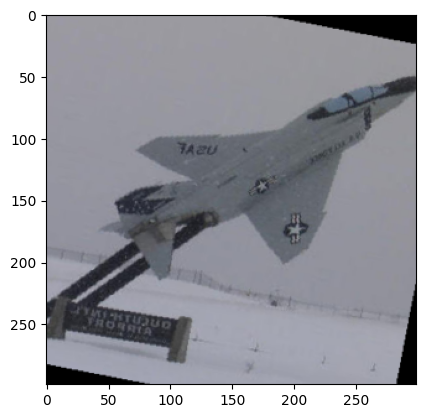

In [7]:
#visualize an image from train_dataset

i = 1135

image = train_dataset[i][0].permute(1, 2, 0).numpy()
label = mapping[str(train_dataset[i][1]+1)] #+1 is required, because the "class 1" in folders, is class 0 when torch loads it

print(f"label: {label} (index - {train_dataset[i][1]+1})")
plt.imshow(image)

In [53]:
model = timm.create_model("xception", pretrained=True, num_classes=256)

for p in model.parameters():
    p.requires_grad = False

for p in model.fc.parameters():
    p.requires_grad=True

model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters())

In [ ]:
timm.models.xception.Xception

timm.models.xception.Xception

In [58]:
for epoch in range(1):

    start = time.time()
    total_training_loss = 0
    total_training_samples = 0
    total_training_correct_classfied = 0

    iteration_start = time.time()

    model.train()

    for iteration, (images, labels) in enumerate(train_loader):

        images = images.to(device)
        labels = labels.to(device)

        output_predictions = model(images)

        loss_value = criterion(output_predictions, labels)

        optimizer.zero_grad()
        loss_value.backward()
        optimizer.step()
        optimizer.zero_grad()

        

        
        total_training_loss += loss_value.item()*labels.shape[0]
        total_training_samples += labels.shape[0]
        _, predicted = torch.max(output_predictions, dim=1)
        total_training_correct_classfied += (labels == predicted).sum().item()

        if iteration%250==0:
            print(f"iteration {iteration+1} done., time = {time.time()-iteration_start}")
            iteration_start = time.time()

    print(f"epoch: {epoch+1+1}, train loss: {total_training_loss/total_training_samples}, train accuracy: {total_training_correct_classfied/total_training_samples}, time taken: {time.time()-start}")

    # if (epoch-1)%3==0:
    #     print_test_details(model, criterion, test_loader)   
    print()





iteration 1 done., time = 3.346224546432495
iteration 251 done., time = 132.98817586898804
iteration 501 done., time = 110.1577296257019
epoch: 2, train loss: 0.7525496218050783, train accuracy: 0.8159838817998657, time taken: 353.4922435283661



In [59]:
from main import print_test_details

print_test_details(model, criterion, test_loader)

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
Test Score - Loss: 0.5806602939684745, top-1 accuracy: 0.8564472800537274, top-5 accuracy: 0.9592008059100067


(0.5806602939684745,
 np.float64(0.8564472800537274),
 np.float64(0.9592008059100067))

In [38]:
# output = nn.functional.softmax(model(x[0:1]), dim=1)
y[0]

tensor(137)

In [32]:
output.std()

tensor(0.0003, grad_fn=<StdBackward0>)

In [27]:
y[0]

tensor(137)